# Lab. 8 Autoencoders


In [1]:
%matplotlib inline

from utils.draw_utils import plot_digits

import torch
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.pyplot as plt

import numpy as np


torch.manual_seed(1337) 
batch_size = 64 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(root='./data/', 
                   train=True, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

## Zadanie 1: Vanilla Autoencoder

Zaimplementować Autoenkoder z 5 warstwami liniowymi (z nieliniową aktywacją np. `tanh`) w enkoderze: 
   * wejściowa (rozmiar cyfry z MNISTA)
   * rozmiaru 128
   * rozmiaru 64
   * rozmiaru 12
   * rozmiaru `latent_dim`
oraz dekoderem z dokładnie odwrotnym przekształceniem.

In [2]:
class AutoEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim):        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        mnist_dim= 784
        
        self.encoder = nn.Sequential(
            nn.Linear(mnist_dim,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,12),
            nn.Tanh(),
            nn.Linear(12,latent_dim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,12),
            nn.Tanh(),
            nn.Linear(12,64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,mnist_dim),
            nn.Sigmoid(),           
        )
                
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        return self.encoder(x)
    

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    

## Zadanie 2: Pętla Uczenia

c:\bin\python36\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Epoch:  0 | train loss: 0.2322


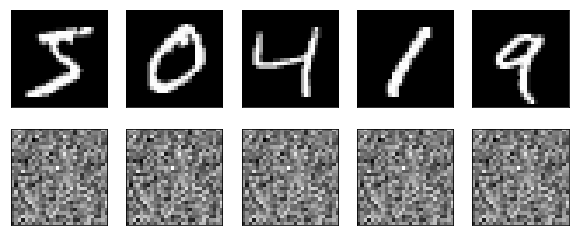

Epoch:  0 | train loss: 0.0597


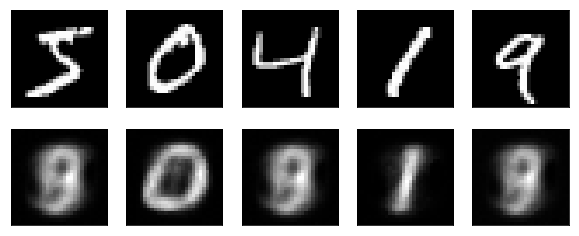

Epoch:  1 | train loss: 0.0537


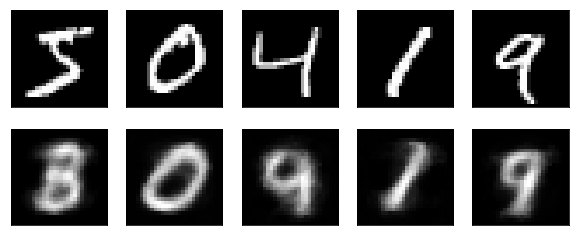

Epoch:  1 | train loss: 0.0445


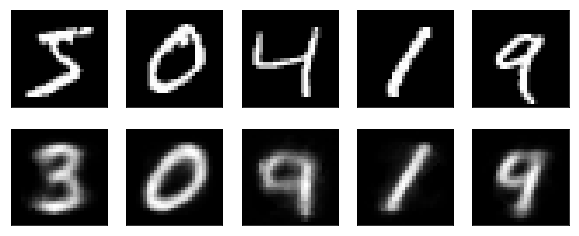

Epoch:  2 | train loss: 0.0431


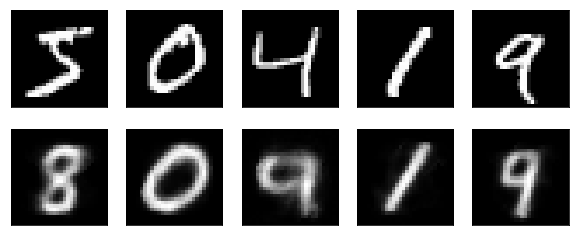

Epoch:  2 | train loss: 0.0416


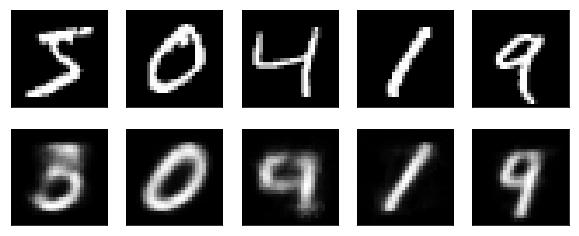

Epoch:  3 | train loss: 0.0389


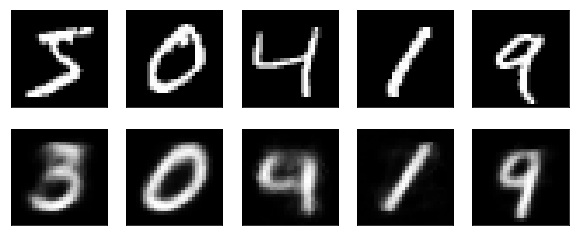

Epoch:  3 | train loss: 0.0414


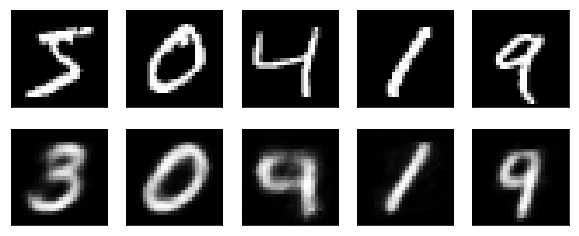

Epoch:  4 | train loss: 0.0365


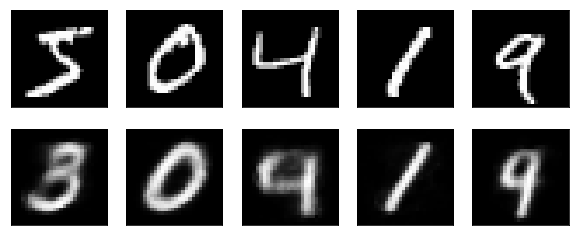

Epoch:  4 | train loss: 0.0397


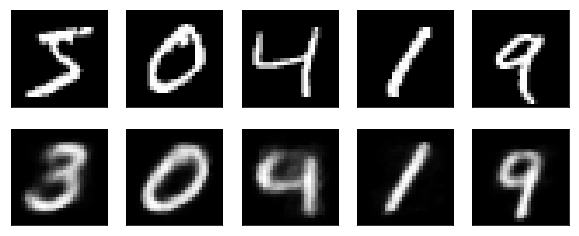

Epoch:  5 | train loss: 0.0362


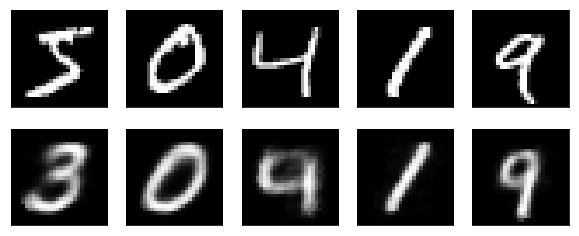

Epoch:  5 | train loss: 0.0353


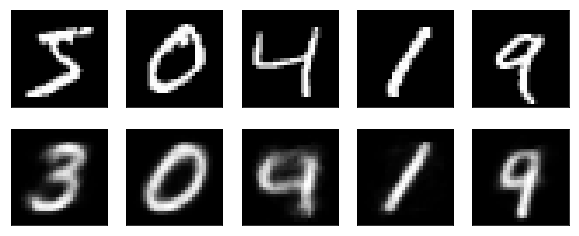

Epoch:  6 | train loss: 0.0404


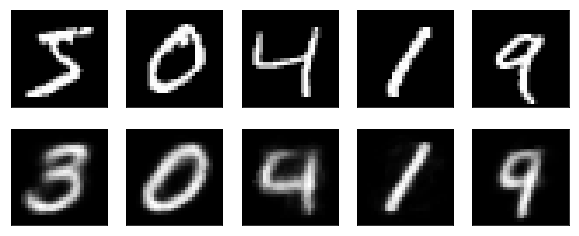

Epoch:  6 | train loss: 0.0350


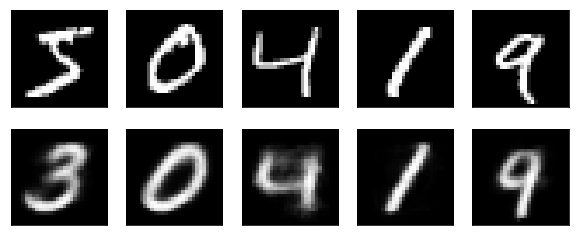

Epoch:  7 | train loss: 0.0383


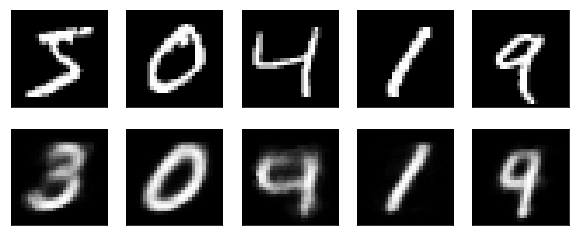

Epoch:  7 | train loss: 0.0345


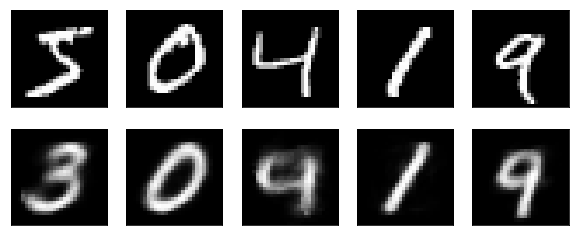

Epoch:  8 | train loss: 0.0338


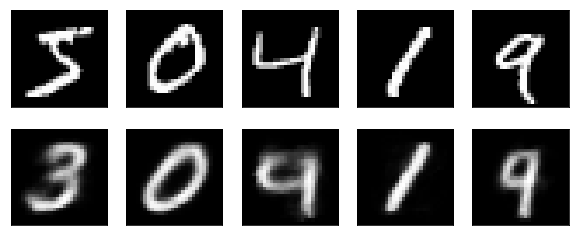

Epoch:  8 | train loss: 0.0364


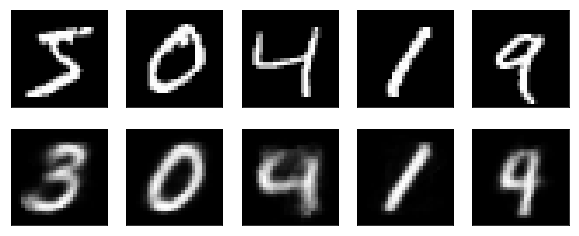

Epoch:  9 | train loss: 0.0327


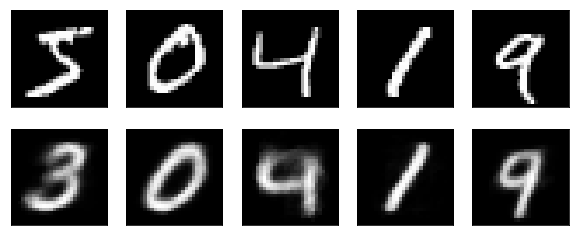

Epoch:  9 | train loss: 0.0338


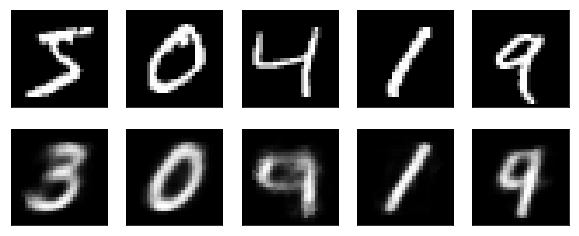

In [3]:
# Hyper Parameters
epochs = 10
lr = 0.005 
n_plots = 5

# prepare original data for plotting
view_data = train_data.train_data[:n_plots].view(-1, 28*28).type(torch.FloatTensor) / 255.

autoencoder = AutoEncoder(latent_dim=3)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = nn.MSELoss()


for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):

        encoded, decoded = autoencoder(x)

        loss = loss_func(decoded, x) # calculate loss
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 500 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            plot_digits(view_data, decoded_data)

# Zadanie 3: "Generowanie" z Autoenkodera

Teoretycznie nasz "vanilla" autoenkoder nie ma naturalnych właściwości generatywnych (więcej w przyszłości przy VAE), ale mimo to spróbujmy wygenerować z niego nowe przykłady.

1. Załóżmy, że nasz autoenkoder układa dane "w środku" w rozkład normalny. Waszym zadaniem jest oszacowanie średniej i wariancji tego rozkładu dla `n` przykładów ze zbioru trenującego. Należy to zrobić na podstawie części zbioru trenującego.

In [4]:
samples = []
n = 500

for step, (x, y) in enumerate(train_loader):
    
    if len(samples) > n:
        break
    
    # encode the points into the latent space and save for later estimation
    encoded = autoencoder.encode(x)
    samples.append(encoded.detach().numpy())
    
    
sampled_z = np.concatenate(samples, axis=0)

# compute mean and std of the empirical distribution in the latent space 
mean_z = np.mean(sampled_z)
std_z = np.std(sampled_z)
mean_z_3 = np.mean(sampled_z, axis=0)
std_z_3 = np.std(sampled_z, axis=0)

2. Używając rozkładu normalnego sparametryzowanego policzonymi momentami wylosuj kilka przykład i zwizualizuj ich rekonstrukcje.

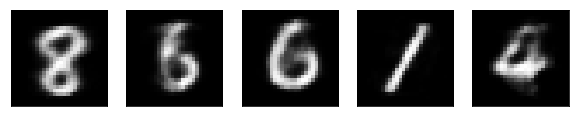

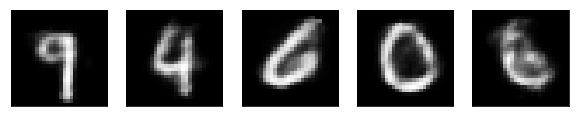

In [5]:
z_sampled = torch.Tensor(np.random.normal(mean_z, std_z, (5,3)))
x_decoded = autoencoder.decode(z_sampled) # decode the sampled points
plot_digits(x_decoded)

sample_3_1 = np.random.normal(mean_z_3[0], std_z_3[0], 5).reshape(1,5).T
sample_3_2 = np.random.normal(mean_z_3[1], std_z_3[1], 5).reshape(1,5).T
sample_3_3 = np.random.normal(mean_z_3[2], std_z_3[2], 5).reshape(1,5).T
z_sampled_3 = torch.Tensor(np.concatenate((sample_3_1, sample_3_2, sample_3_3), axis=1))
x_decoded_3 = autoencoder.decode(z_sampled_3) # decode the sampled points
plot_digits(x_decoded_3)

## Zadanie 4. Interpolacja

Dla kilku przykładów ze zbioru trenującego zaimplementuj interpolacje pomiedzy parą punktów w przestrzeni _latent_, następnie zdekoduj te interpolacje i zwizualizuj wynik. Dla przypomnienie, liniowa interpolacja:


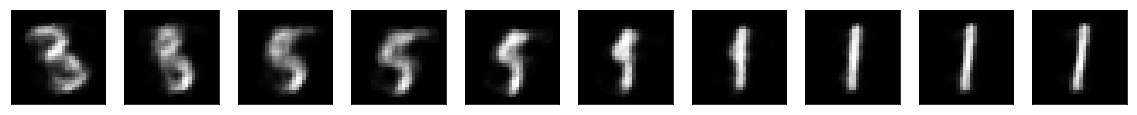

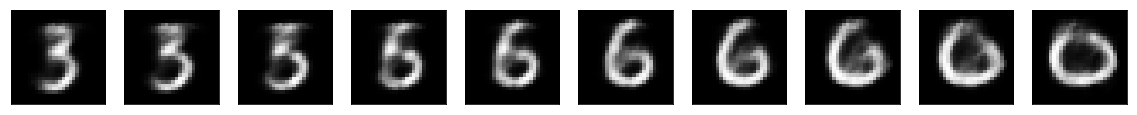

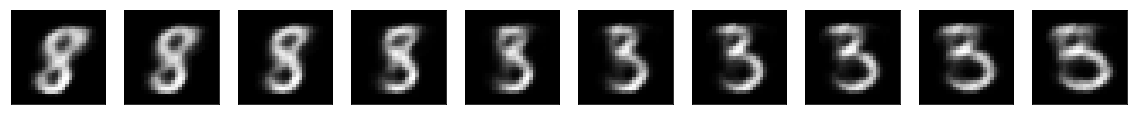

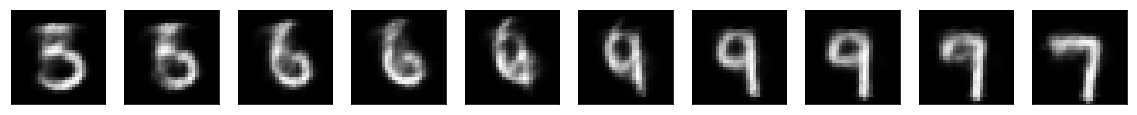

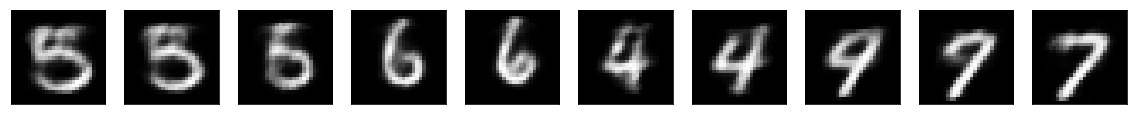

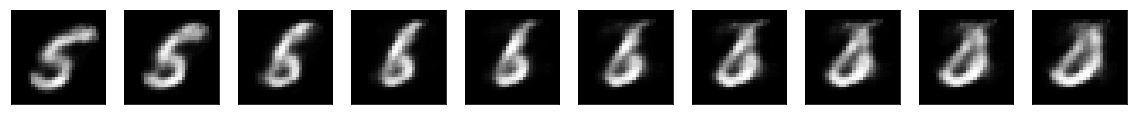

In [6]:
n_interpolations = 5

for step, (x, y) in enumerate(train_loader):
    if step > n_interpolations:
        break
    
    x_1 = x[0, :]
    x_2 = x[1, :]
    
    z_1 = autoencoder.encode(x_1)
    z_2 = autoencoder.encode(x_2)
    
    x_interpolated = []
    
    for i, alpha in enumerate(np.linspace(0, 1, 10)):
        z_int = (1 - alpha) * z_1 + alpha * z_2 # interpolate in the latent space
        x_int = autoencoder.decode(z_int) # decode the interpolated sample
        
        x_interpolated.append(x_int)
    
    x_interpolated = torch.stack(x_interpolated, dim=0)
    
    plot_digits(x_interpolated)
